# Exercise 1(Retail Data Store)
 We first ask ourself about the selling in the Store, in order to do that we first separate out data by Categories our Store offer us and then we compute the average

In [7]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from fbprophet import Prophet

In [2]:
warnings.filterwarnings("ignore")
orders=pd.read_excel('Superstore.xls',sheet_name='Orders')
returns=pd.read_excel('Superstore.xls',sheet_name='Returns')
people=pd.read_excel('Superstore.xls',sheet_name='People')
Ords_Ret=pd.merge(orders,returns,how='outer').sort_values('Order Date')
Ords_Ret=Ords_Ret[["Category","Sales",'Order Date','Returned']]
df=Ords_Ret.set_index('Order Date').groupby('Category').resample('M').mean().unstack(0)['Sales']
df.columns.name=''

# Results as a function of time

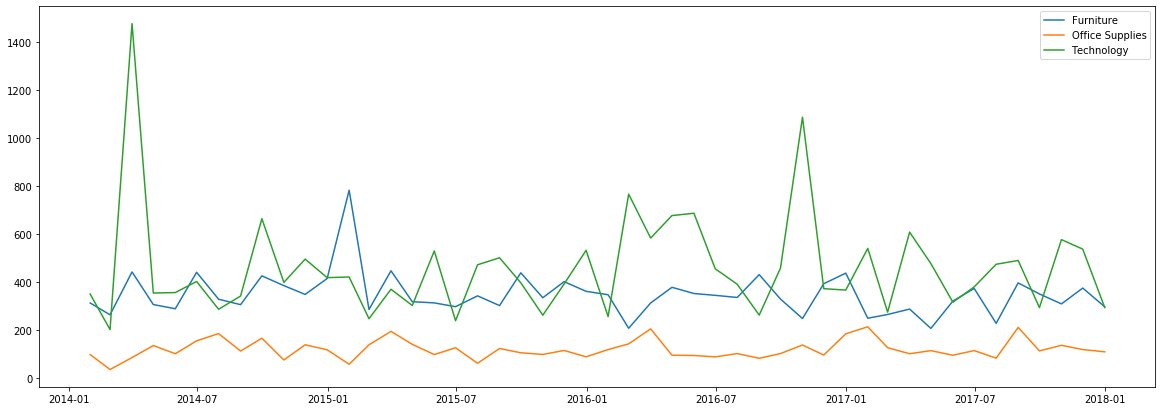

In [3]:
plt.figure(figsize=(20,7))
for i in df.keys():
    plt.plot(df.reset_index()['Order Date'],df[i],label=i)
plt.legend()
plt.show()

In [5]:
furniture= df.Furniture
office = df['Office Supplies']
technology = df.Technology

In [19]:
def Compute_decomposition(dfs):
    results=[]
    for i in range(len(dfs)):
        decomposition = sm.tsa.seasonal_decompose(dfs[i], model='additive')
        results.append(decomposition)
    return results

def Plot_decomposition(dfs):
    results=Compute_decomposition(dfs)
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,10),sharex=True)
    for i in range(len(results)):
        ax1.plot(results[i].trend.index,results[i].trend,label=dfs[i].name)
        ax2.plot(results[i].seasonal.index,results[i].seasonal,label=dfs[i].name)
        ax3.plot(results[i].resid.index,results[i].resid,label=dfs[i].name)
    #ax1.set_yscale("log")
    ax1.legend()
    ax2.legend()
    ax3.legend()
    #fig.suptitle('Additive Decomposition Model for {}'.format(title))
    plt.show()

# To see if there is a pattern we compute an additive decomposition of the Signal

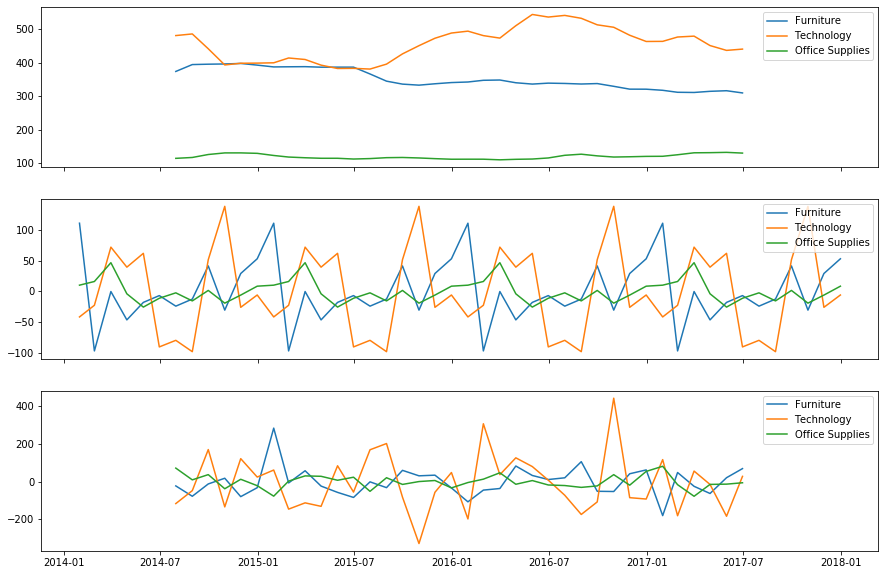

In [21]:
Plot_decomposition([furniture,technology,office])

# Now in order to predict the data and Analyze the the patterns we make use of Prophet (Facebook library) to run our additive model and make use of a Fourier transform to see the patterns of every year.

In [26]:
furniture=df.reset_index()[['Order Date', 'Furniture']]
technology = df.reset_index()[['Order Date', 'Technology']]
office = df.reset_index()[['Order Date', 'Office Supplies']]
def Get_prediction(data,date_column,item_column,mode='additive'):
    df=data.copy()
    df=df.rename(columns={date_column:'ds',item_column:'y'})
    forecast_model = Prophet(interval_width=0.95,seasonality_mode=mode)
    forecast_model.fit(df)
    df_forecast = forecast_model.make_future_dataframe(periods = 6,freq = 'M')
    df_forecast =forecast_model.predict(df_forecast)
    return forecast_model, df_forecast

def Plot_predictions(data,date_column,item_column,mode='additive'):
    a,b=Get_prediction(data,date_column,item_column,mode=mode)
    plt.figure(figsize=(20,7))
    plt.plot(b['ds'],b['yhat'],label='Prediction',color='rebeccapurple')
    plt.plot(data[date_column],data[item_column],label='Real',color='forestgreen')
    plt.fill_between(b['ds'],b['yhat_lower'],b['yhat_upper'],alpha=0.2,color='rebeccapurple')
    plt.xticks(rotation=45)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('{} Predictions'.format(item_column))
    plt.show()
def Plot_components(data,date_column,item_column,mode='additive'):
    a,b=Get_prediction(data,date_column,item_column,mode=mode)
    a.plot_components(b)
    plt.show()

# Furniture

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


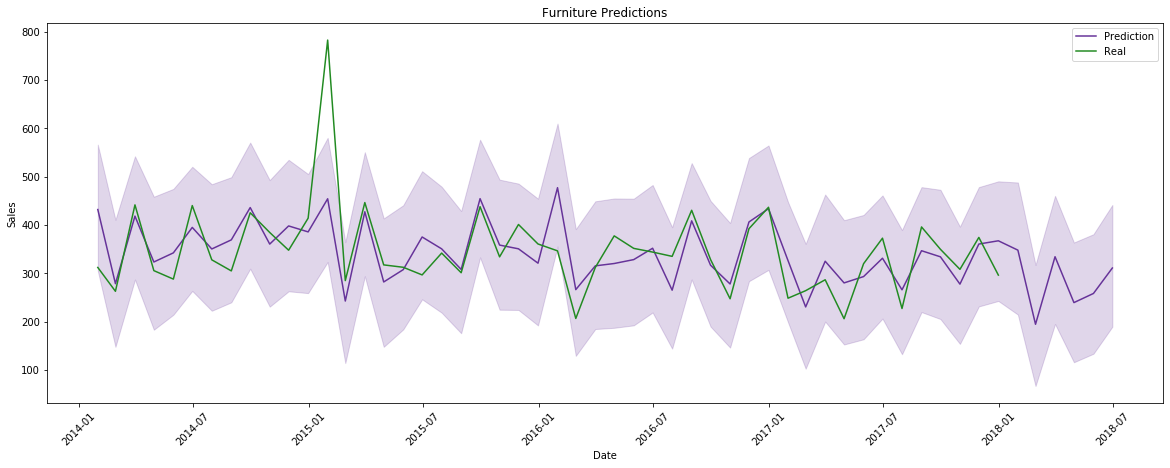

In [27]:
Plot_predictions(furniture,'Order Date', 'Furniture')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


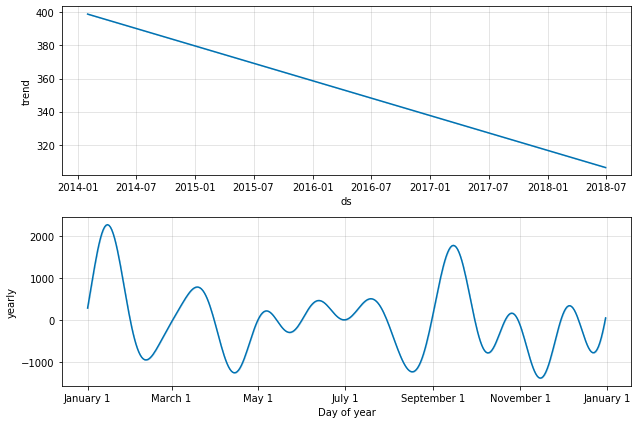

In [28]:
Plot_components(furniture,'Order Date', 'Furniture')

# Technology

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


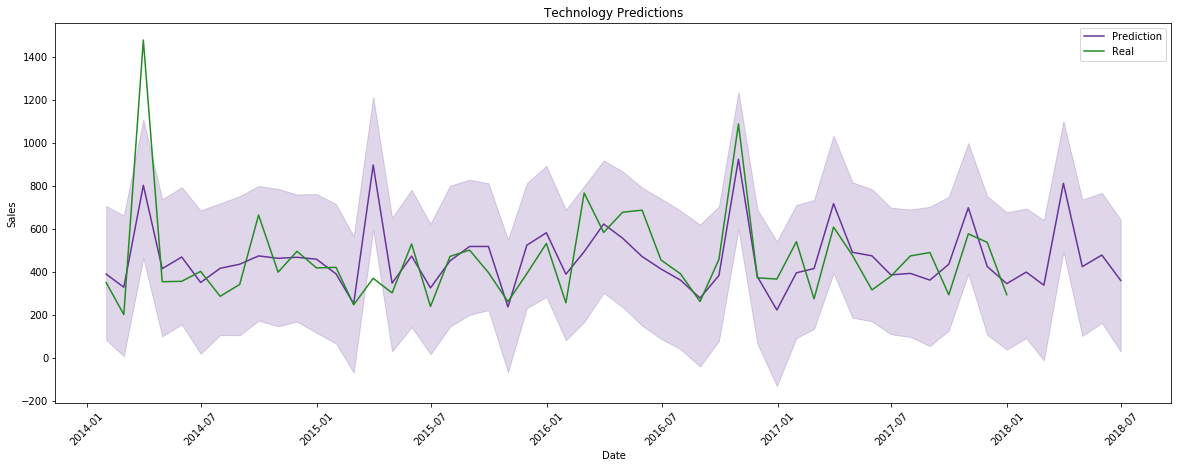

In [29]:
Plot_predictions(technology,'Order Date', 'Technology')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


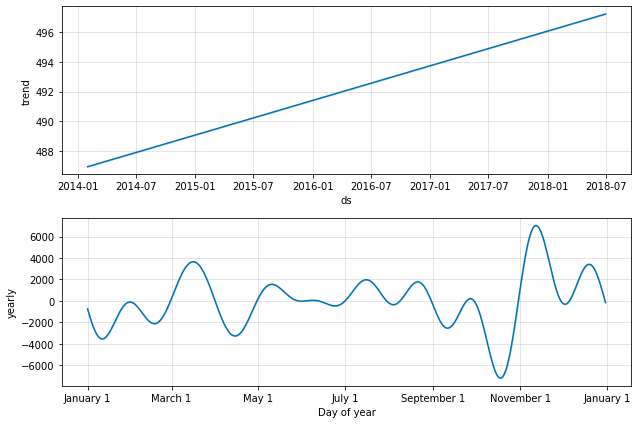

In [30]:
Plot_components(technology,'Order Date', 'Technology')

# Office supplies

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


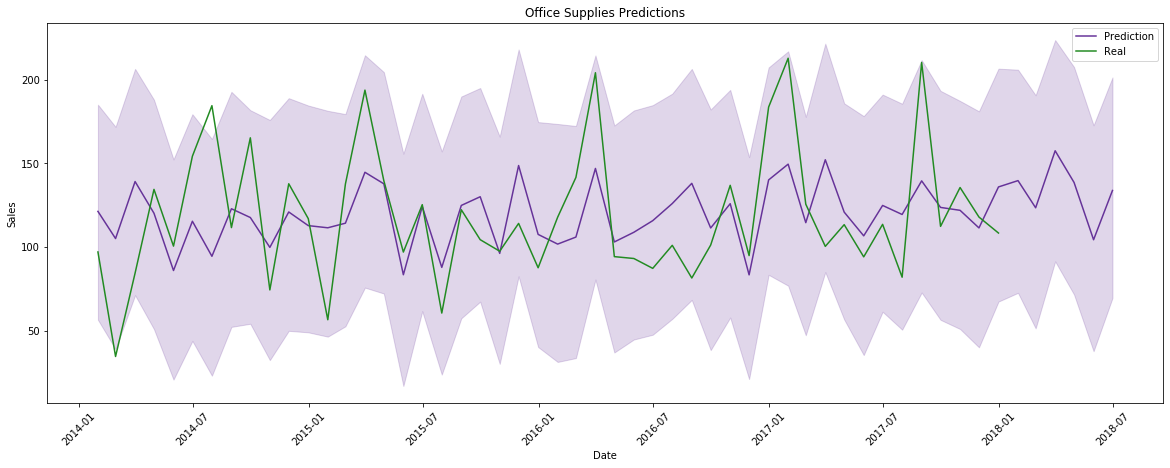

In [31]:
Plot_predictions(office,'Order Date', 'Office Supplies',mode='additive')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


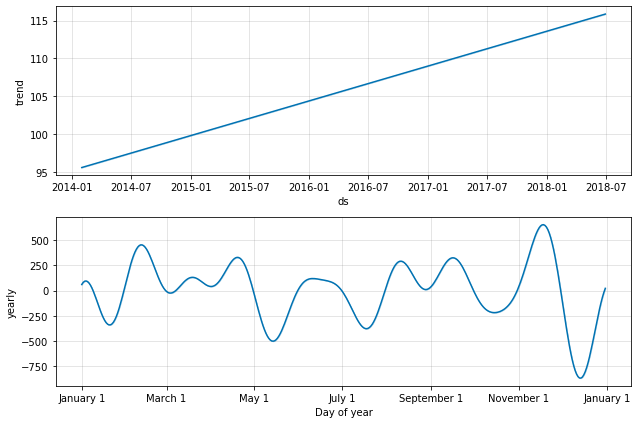

In [32]:
Plot_components(office,'Order Date', 'Office Supplies',mode='additive')

# In conclusion we have that:

* __All Categories, except by Furniture, are growing in time.__

* __It seems that for all 3 Categories the worst months are between October and December Indicating that a good strategy for these months is to make some discounts in these dates.__

* __An additive model recreates pretty well the behaviour of the sales, meaning that this can be a model that can be trusted__

In [35]:
a=Get_prediction(furniture,'Order Date', 'Furniture')
b=Get_prediction(office,'Order Date', 'Office Supplies')
c=Get_prediction(technology,'Order Date', 'Technology')
Sells=a[1][['yhat_lower','yhat_upper','yhat']]+b[1][['yhat_lower','yhat_upper','yhat']]+c[1][['yhat_lower','yhat_upper','yhat']]
Sells['date']=a[1]['ds']

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


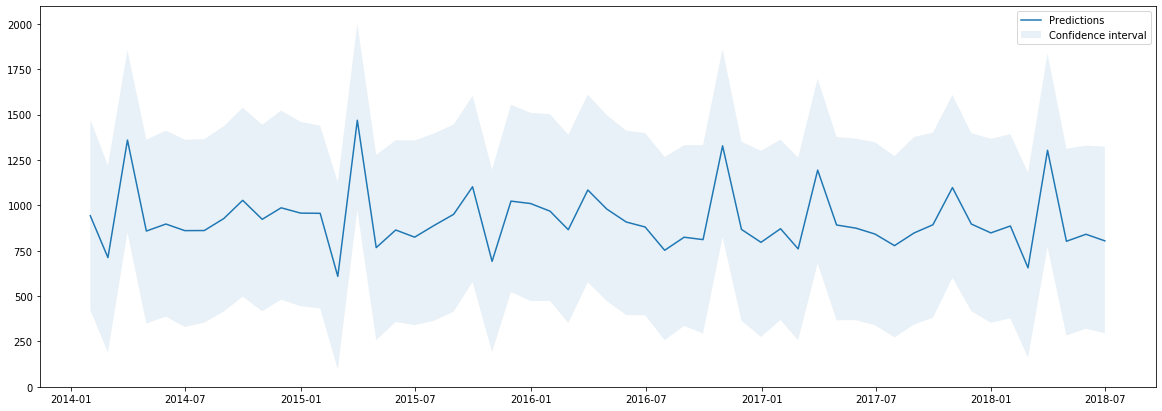

In [38]:
plt.figure(figsize=(20,7))
plt.plot(Sells['date'],Sells['yhat'],label='Predictions')
plt.fill_between(Sells['date'],Sells['yhat_lower'],Sells['yhat_upper'],alpha=0.1,label='Confidence interval')
plt.legend()
plt.show()

# Results of total average Selling for the next 6 months

In [40]:
Sells['Prediction']=np.round(Sells['yhat'],2).astype(str)+ r'$\pm$' + np.round(((-Sells['yhat']+Sells['yhat_upper'])+(Sells['yhat']-Sells['yhat_lower']))/2,2).astype(str)


In [41]:
Sells[['date','Prediction']].tail(6)

,date,Prediction
48,2018-01-31,886.0$\pm$507.77
49,2018-02-28,655.33$\pm$509.81
50,2018-03-31,1303.29$\pm$533.2
51,2018-04-30,801.72$\pm$514.64
52,2018-05-31,840.42$\pm$504.5
53,2018-06-30,804.08$\pm$514.43


# Best Selling Articles
## In order to study the relation between the cost and the profit we look at the Sub categories that the store offer us

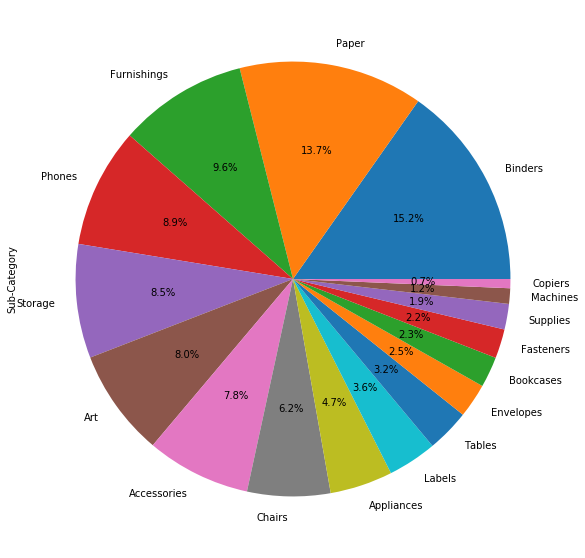

In [42]:
plt.figure(figsize=(12,10))
orders['Sub-Category'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

# But more important than just our Selling we have to look at the relation Selling Profit.

## So we can look this relation for each article

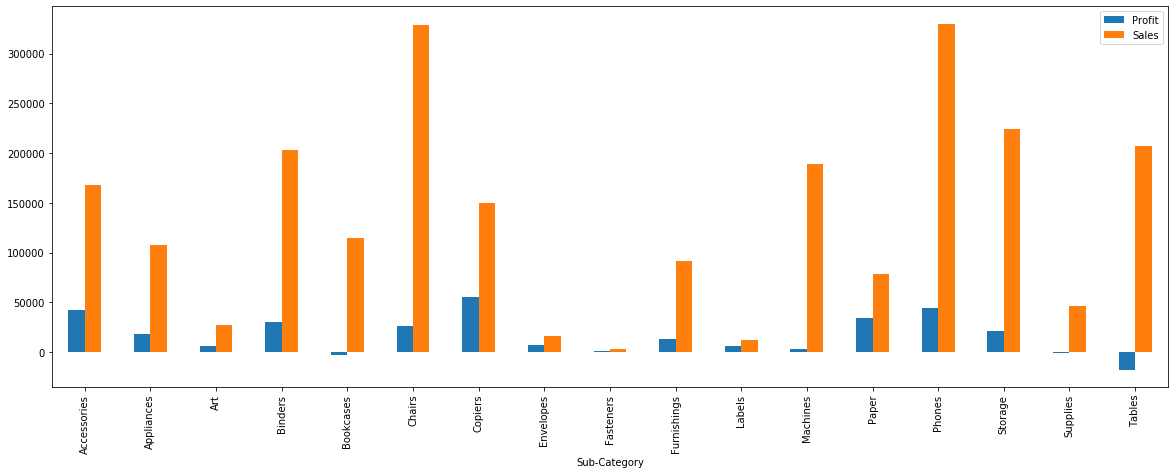

In [44]:
tmp=orders.groupby('Sub-Category')['Profit','Sales'].agg(['sum'])
tmp.columns=tmp.columns.droplevel(1)
tmp.plot.bar(figsize=(20,7))
plt.show()

## From the last plot we can see that even though the store sells many tables the total profit obtained by this selling is actually negative, being this an indication that is time to increase the prices of the tables such that the profit increases.

### Even more we can look at the the places where we sell all these products, for doing so, we look at the number of sold articles per region

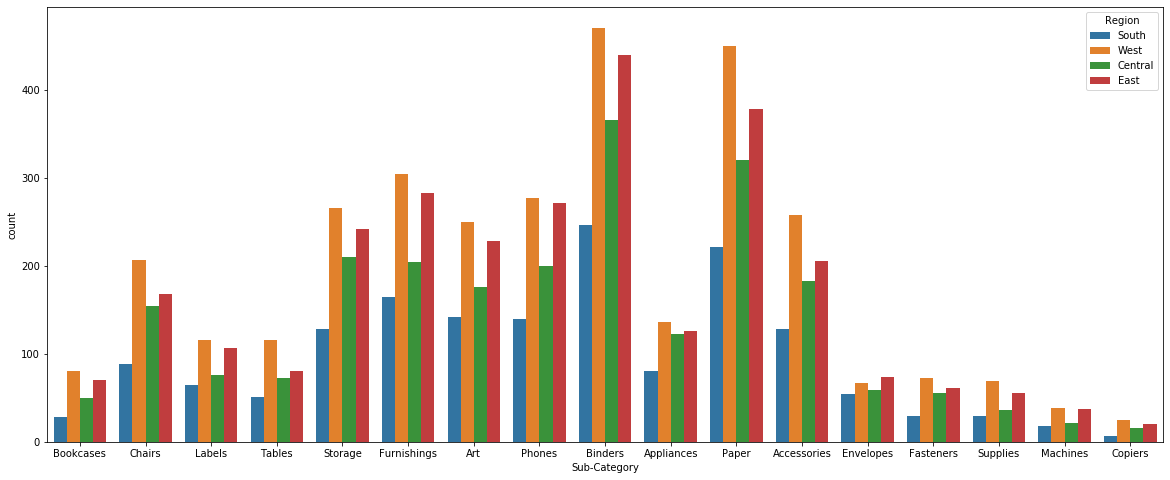

In [45]:
plt.figure(figsize=(20,8))
sns.countplot(x="Sub-Category", hue="Region", data=orders)
plt.show()

### The last figure could be used as a reference of how we can distribute our products around the country.

# Costs and profit percentage
### Turning back to our last question, we are interested in the relation between the cost and the profit for every product we sell

In [46]:
orders['Cost']=orders['Sales']-orders['Profit']
orders['Profit %']=(orders['Profit']/orders['Cost'])*100

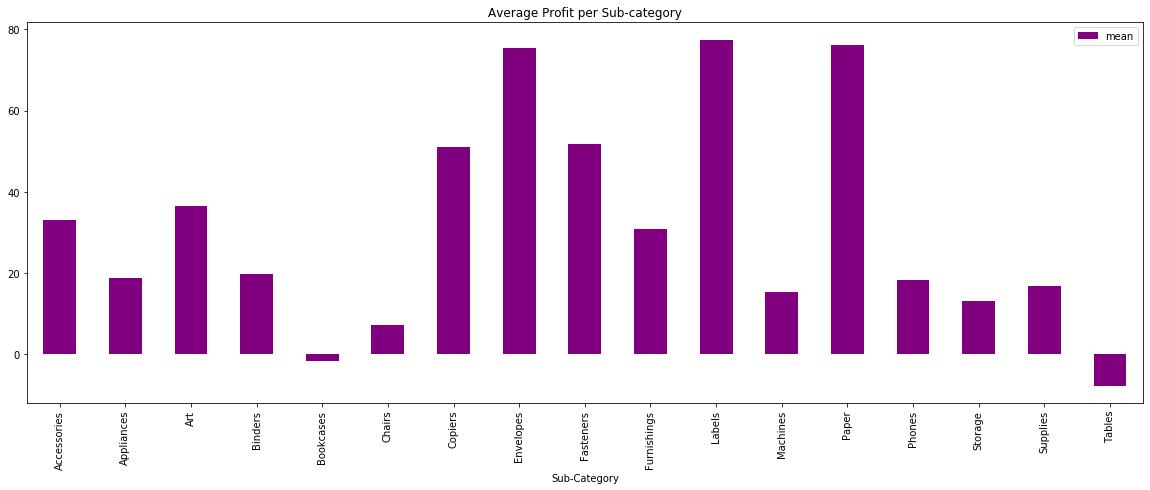

In [48]:
tmp=orders.groupby('Sub-Category')['Profit %'].agg(['mean'])
#tmp.columns=tmp.columns.droplevel(1)
tmp.plot.bar(figsize=(20,7),color="purple")
plt.title('Average Profit per Sub-category')
plt.show()

# From the last plot we confirm the fact that the store is losing money by selling tables at the price it does.

## To finish we look at the relation of profit and sales in every state per year

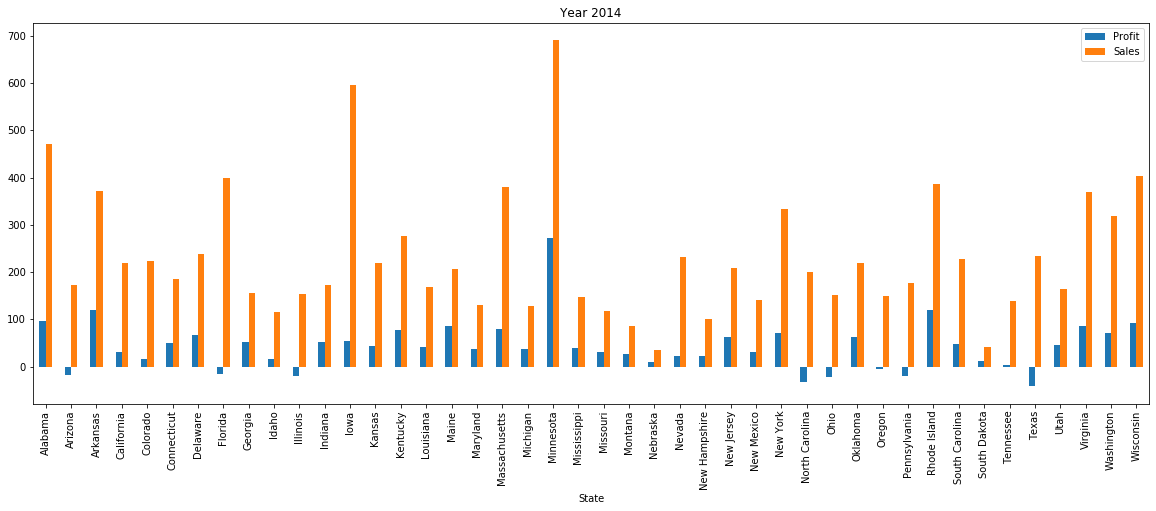

In [49]:
orders[orders["Order Date"].dt.year==2014].groupby("State").mean()[["Profit","Sales"]].plot.bar(figsize=(20,7),title="Year 2014")
plt.show()

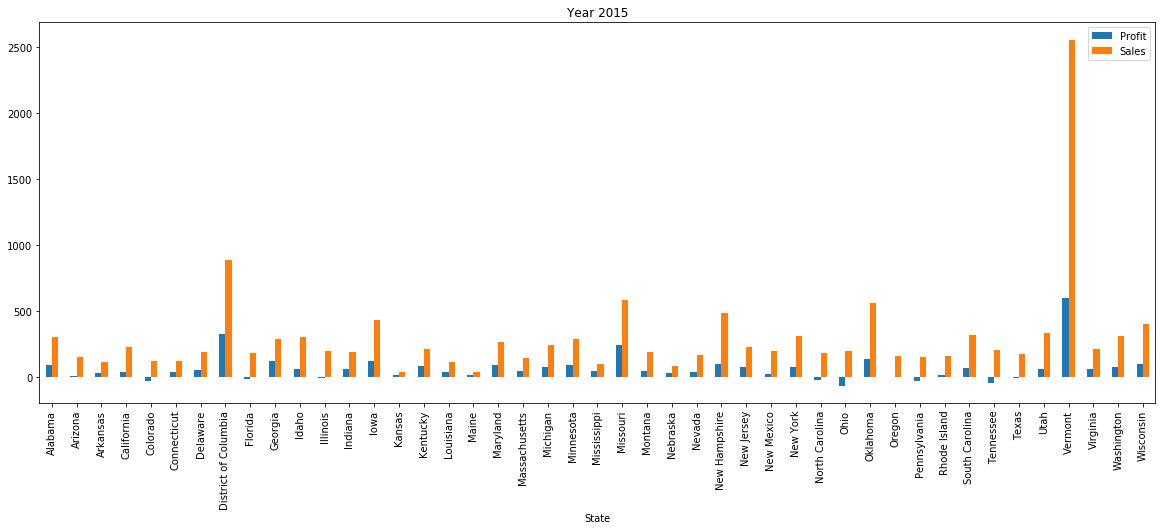

In [50]:
orders[orders["Order Date"].dt.year==2015].groupby("State").mean()[["Profit","Sales"]].plot.bar(figsize=(20,7),title="Year 2015")
plt.show()

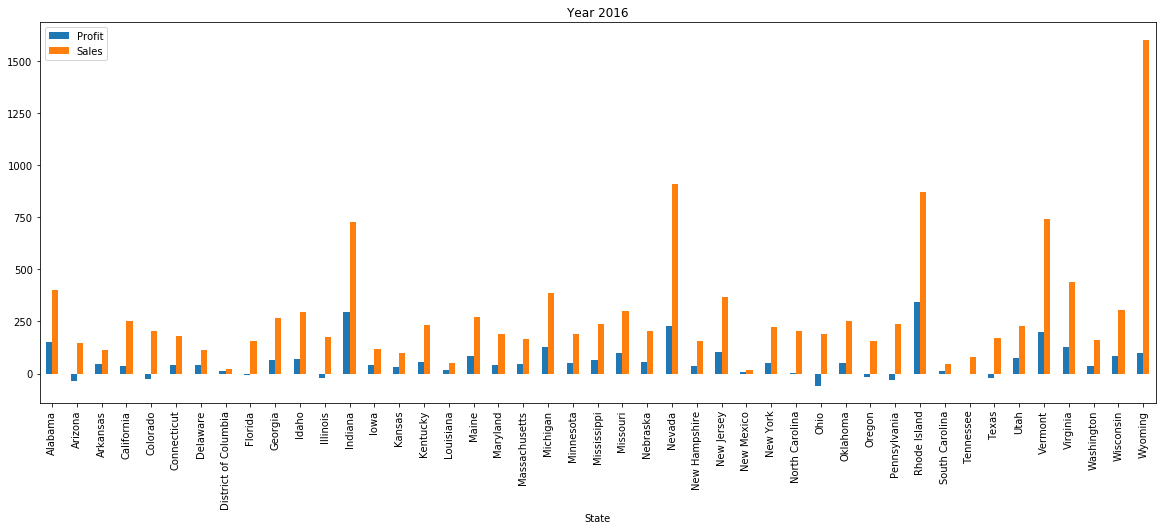

In [51]:
orders[orders["Order Date"].dt.year==2016].groupby("State").mean()[["Profit","Sales"]].plot.bar(figsize=(20,7),title="Year 2016")
plt.show()

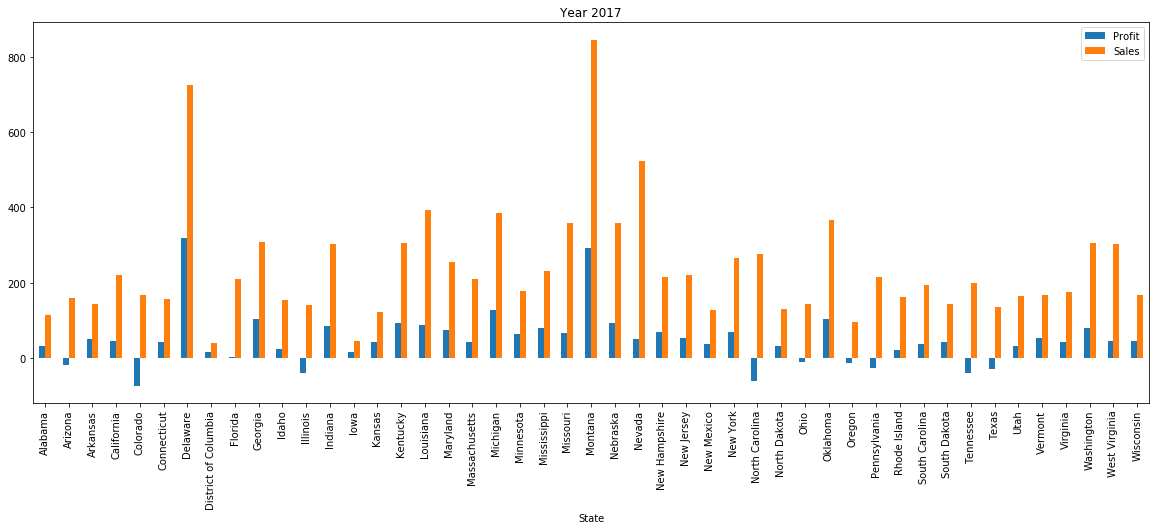

In [52]:
orders[orders["Order Date"].dt.year==2017].groupby("State").mean()[["Profit","Sales"]].plot.bar(figsize=(20,7),title="Year 2017")
plt.show()

# Apparently when the store opens a new branch the sales increase drastically, how ever, as the figures show even though the sells grow, the profit is not necessarily doing so. So it is important to pay attention.

# Exercise 2(Mall Customers)
In this exercise we were asked to implement an algorithm such that could classify our clients based in Gender, income, age and if someone has a propensity to buy something.

In [53]:
data=pd.read_csv('Mall_Customers.csv')

# We can start by asking ourself if there is a difference between women and men, to solve this question we have. 

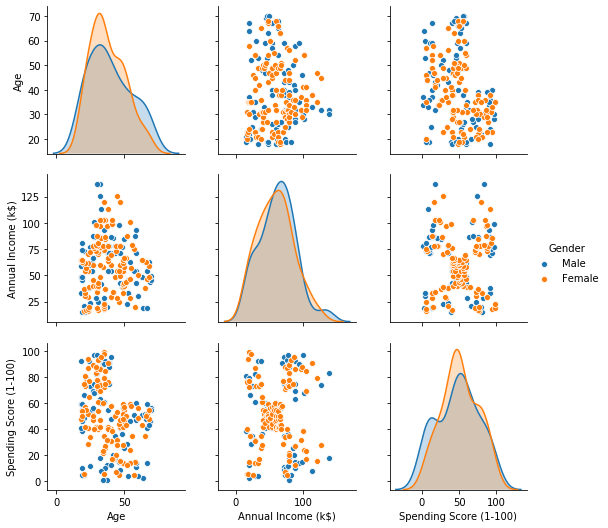

In [54]:
sns.pairplot(data=data[data.columns[1:]],hue='Gender')
plt.show()

### By seeing at this plot we can discard the fact that being a female or male customer affects the in being or not a client for our mall, so we have to treat them equally.

### We search therefore the best way of classify our clients, to do so we are going to use K-Means so we search for the best number of cluster such that the classes are separated enough to consider them a cluster. To find this number we make use of the Silhouette Score  (The calculations are done in the code).

For n_clusters = 2 The average silhouette_score is : 0.33547192894004574
For n_clusters = 3 The average silhouette_score is : 0.35880977401117803
For n_clusters = 4 The average silhouette_score is : 0.4039582785148566
For n_clusters = 5 The average silhouette_score is : 0.41664341513732767
For n_clusters = 6 The average silhouette_score is : 0.42742814991580175
For n_clusters = 7 The average silhouette_score is : 0.417231894954916
For n_clusters = 8 The average silhouette_score is : 0.408443059554235
For n_clusters = 9 The average silhouette_score is : 0.4188078334648395
For n_clusters = 10 The average silhouette_score is : 0.4003965743727067
For n_clusters = 11 The average silhouette_score is : 0.40735982072930627
For n_clusters = 12 The average silhouette_score is : 0.41103506331859635
For n_clusters = 13 The average silhouette_score is : 0.37109188976467833
For n_clusters = 14 The average silhouette_score is : 0.3744783217222762
For n_clusters = 15 The average silhouette_score is : 

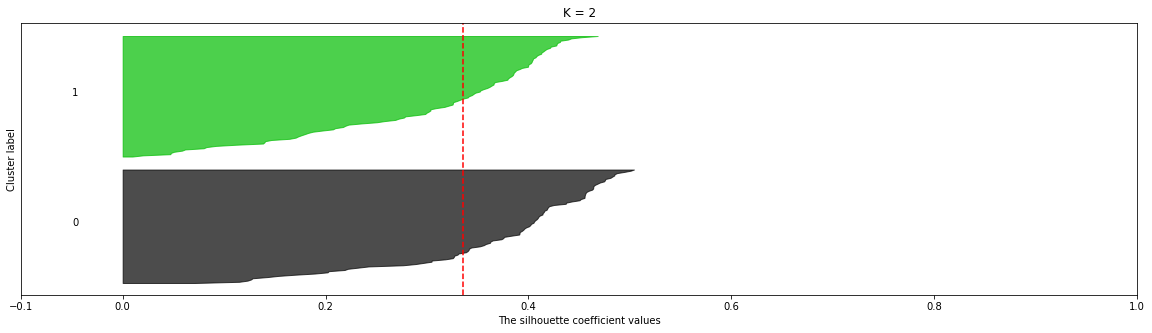

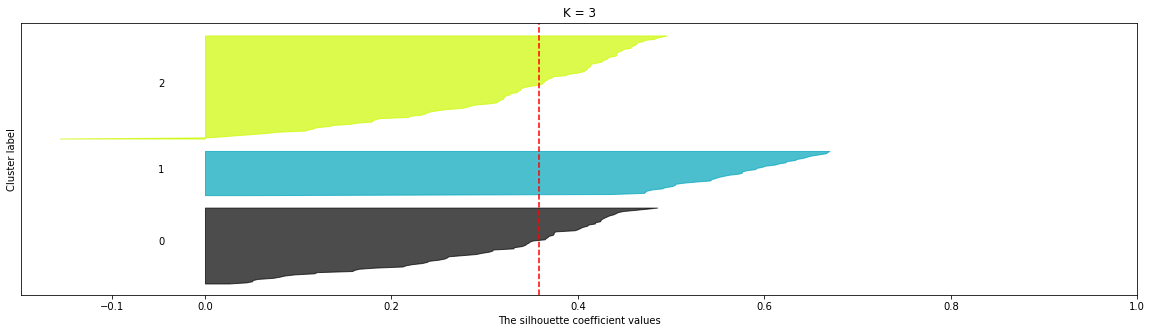

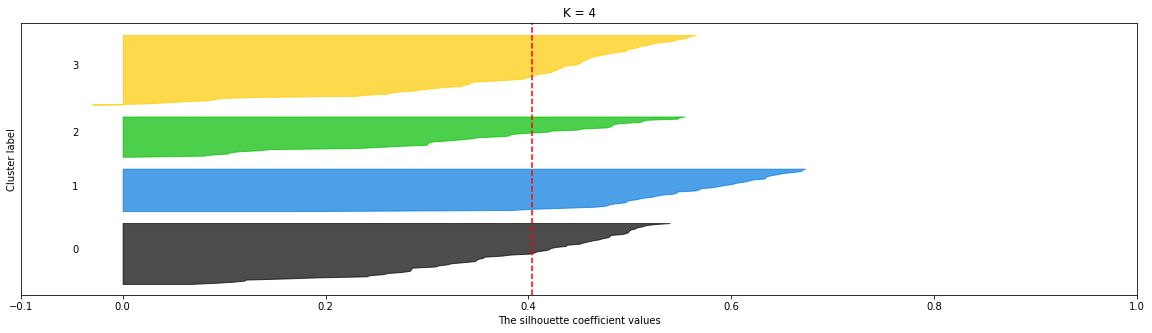

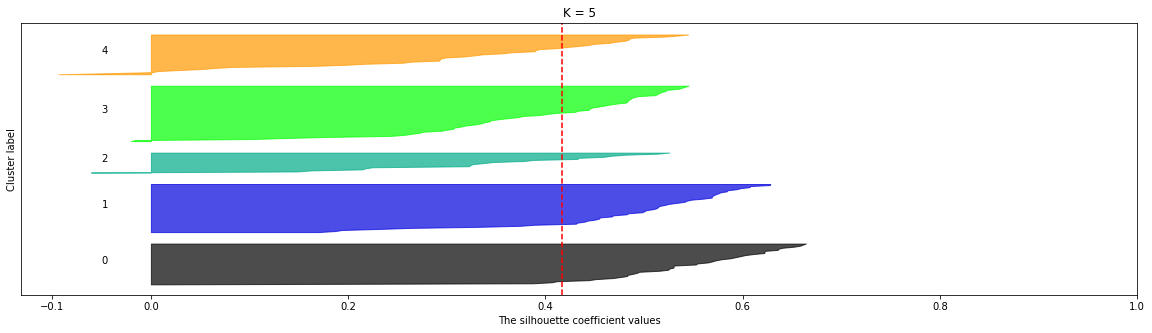

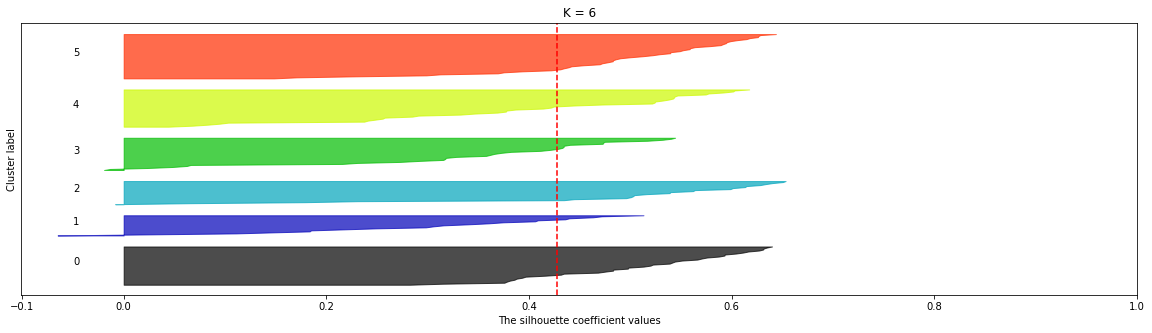

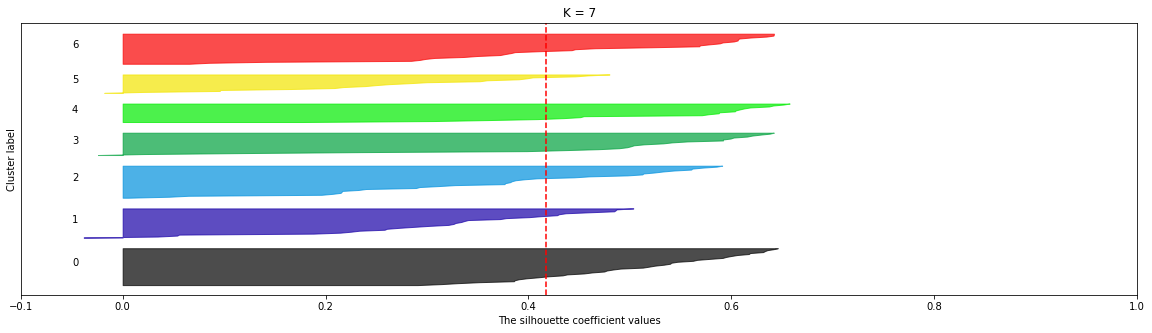

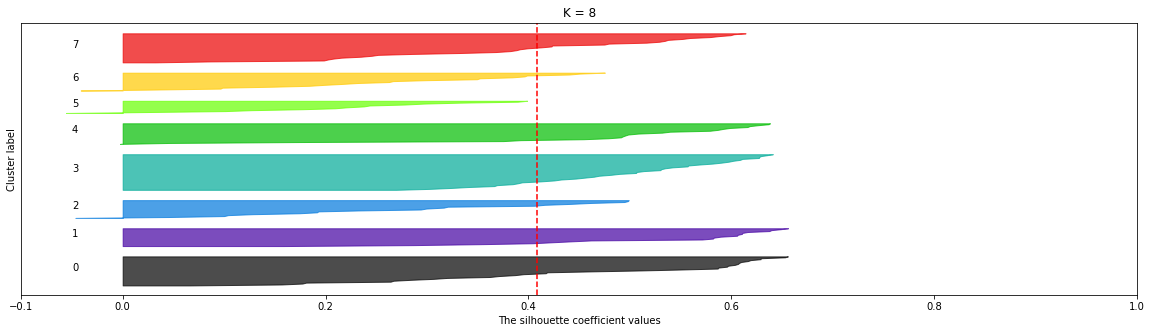

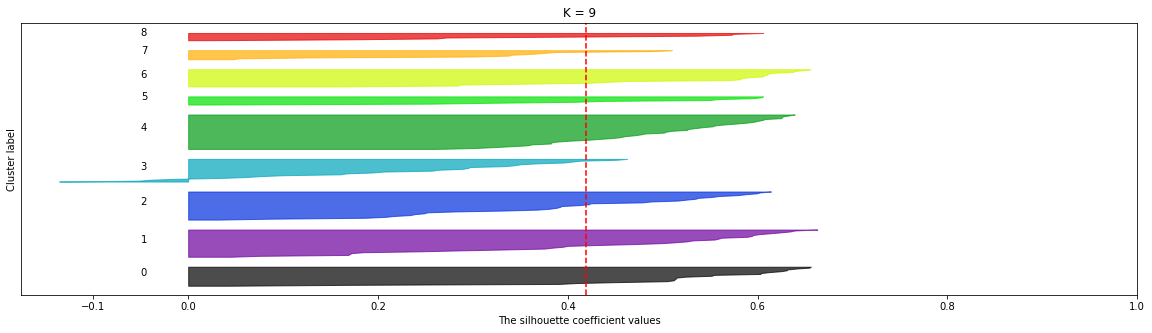

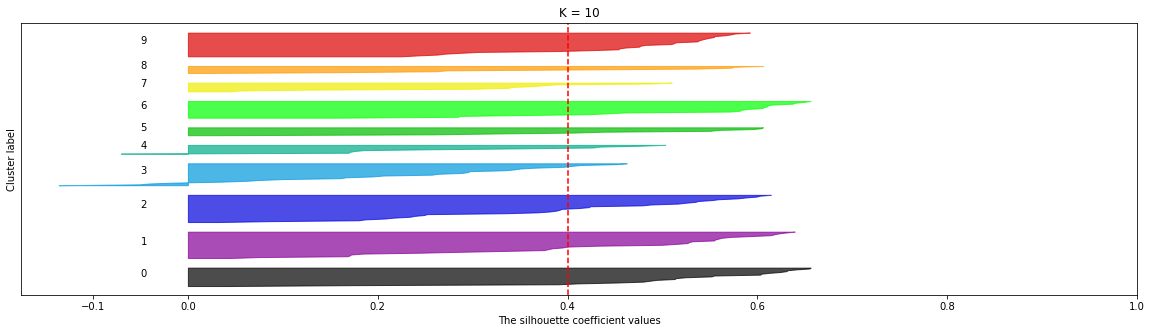

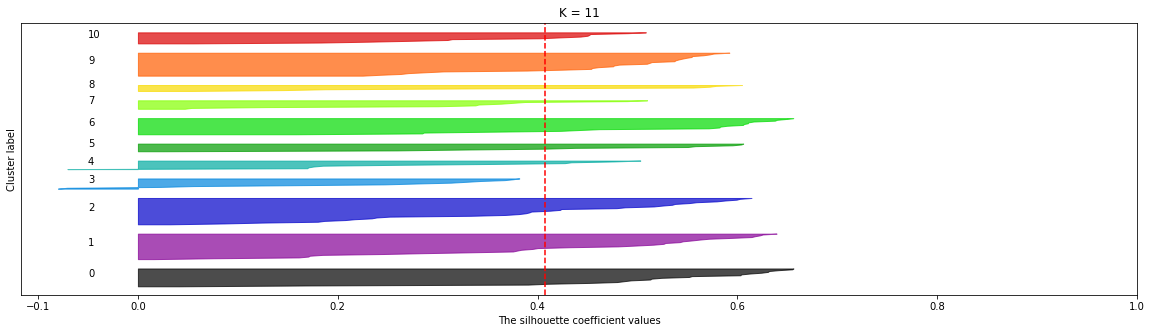

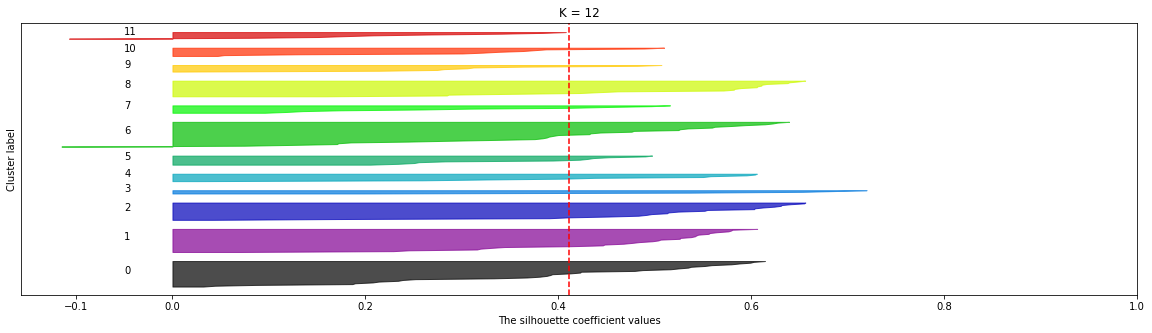

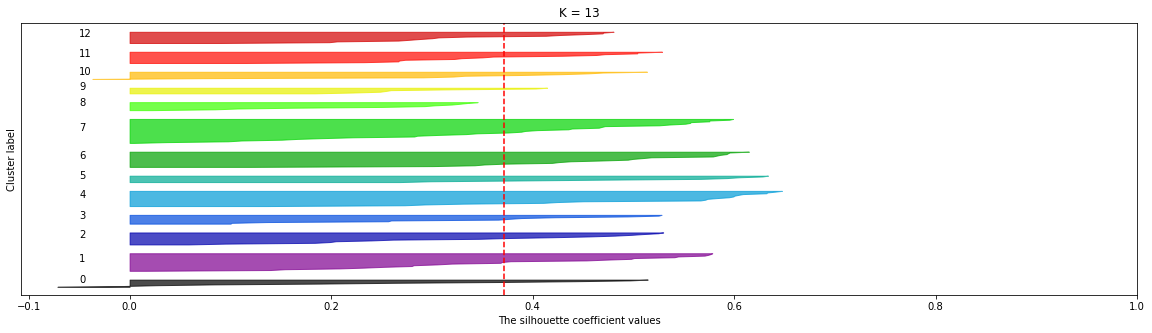

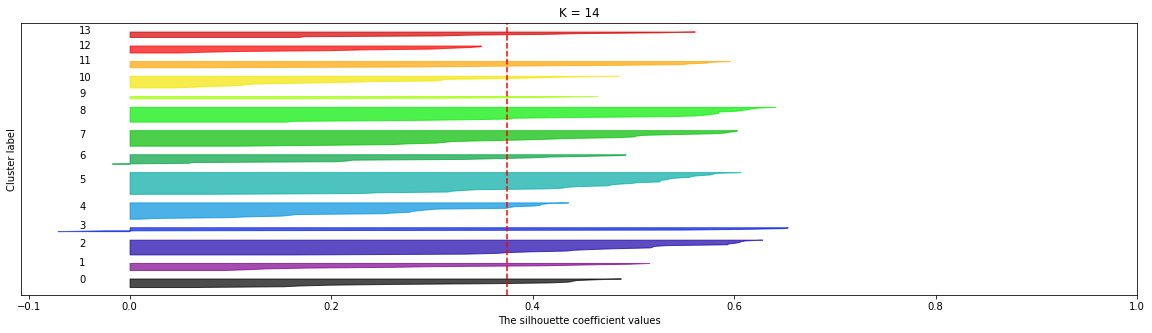

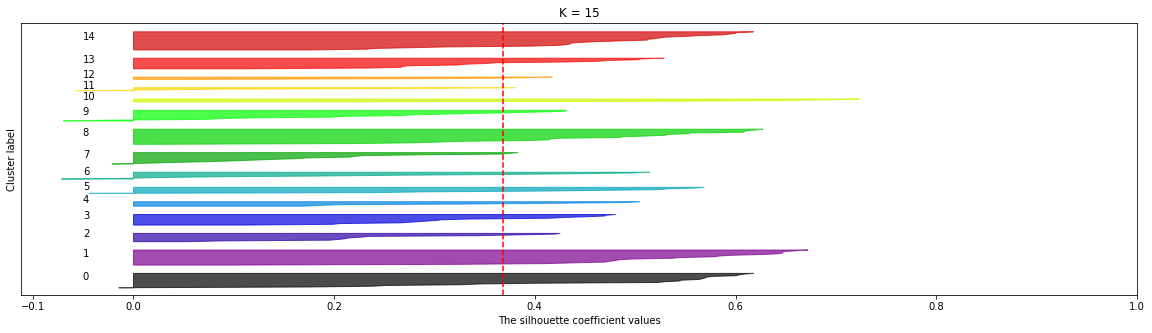

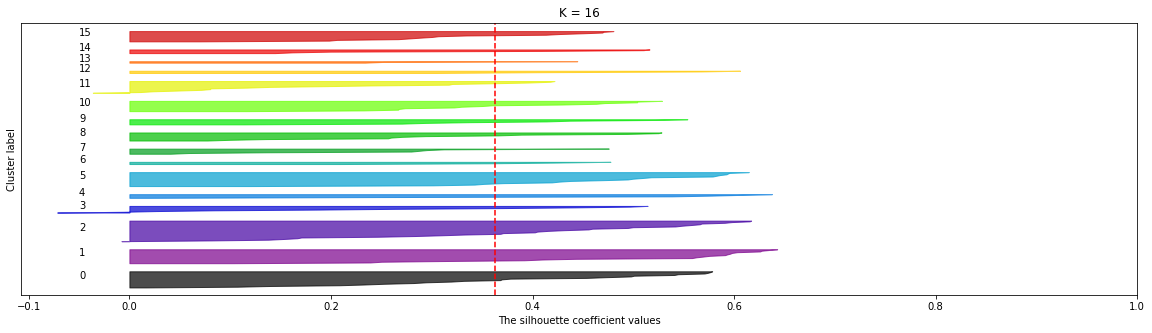

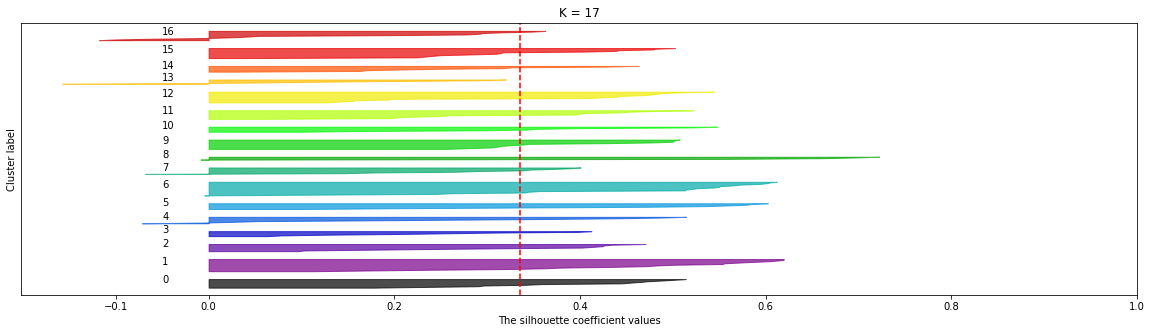

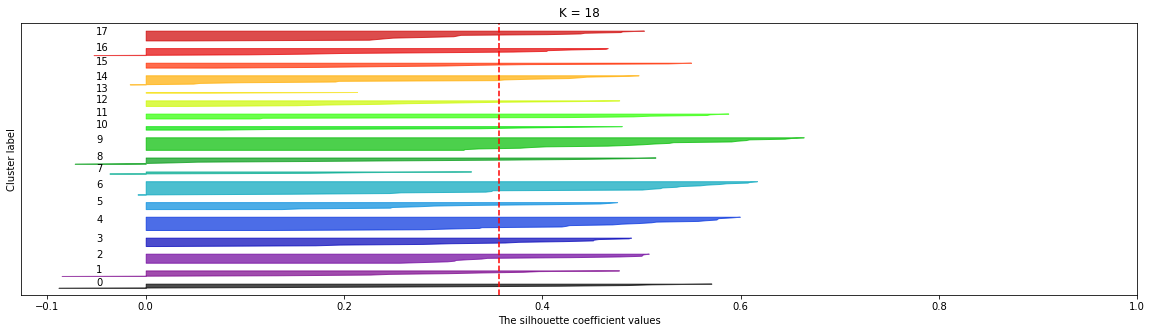

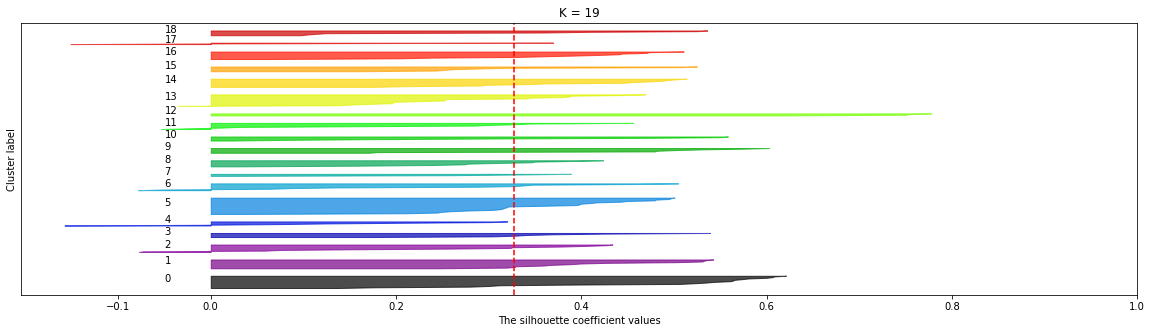

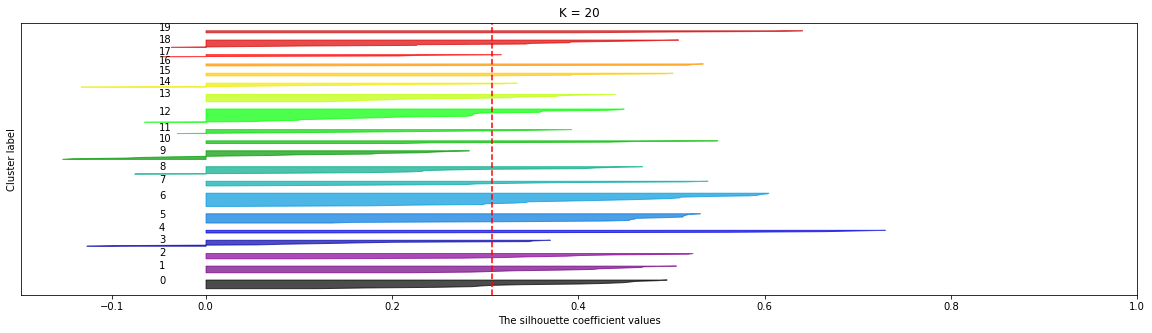

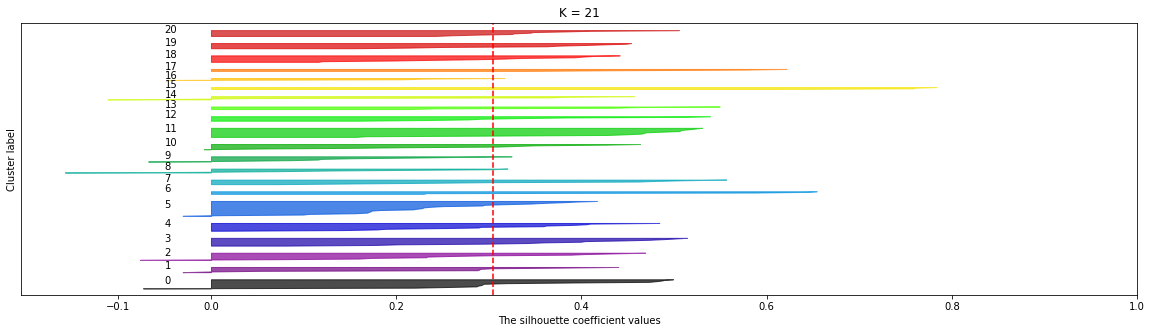

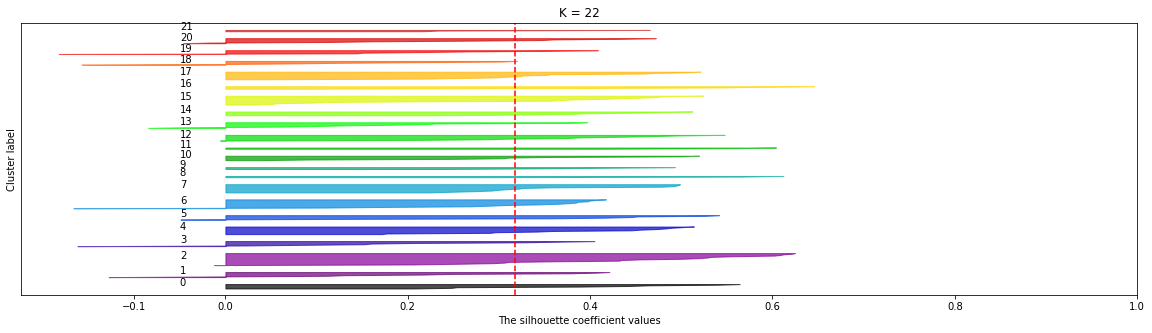

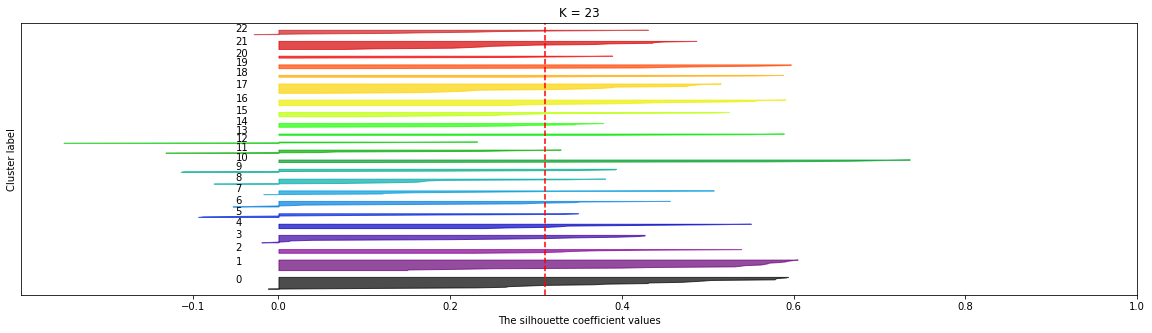

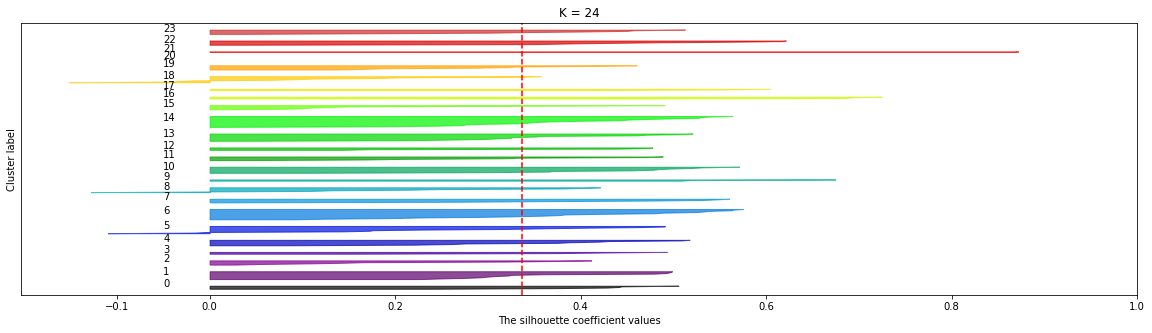

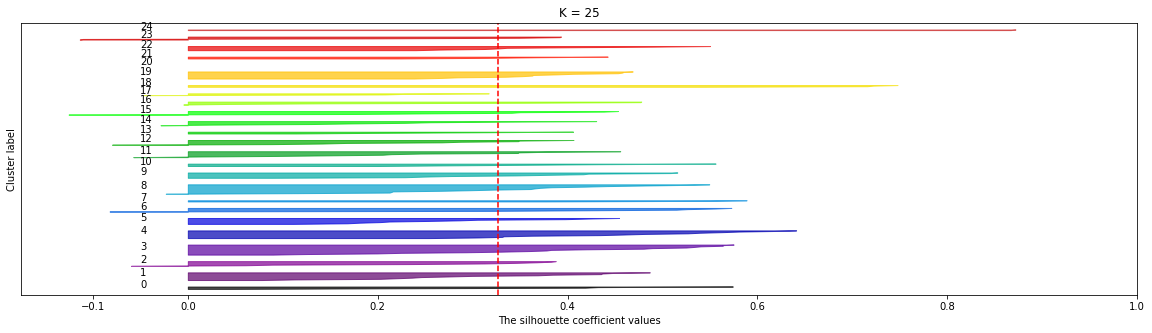

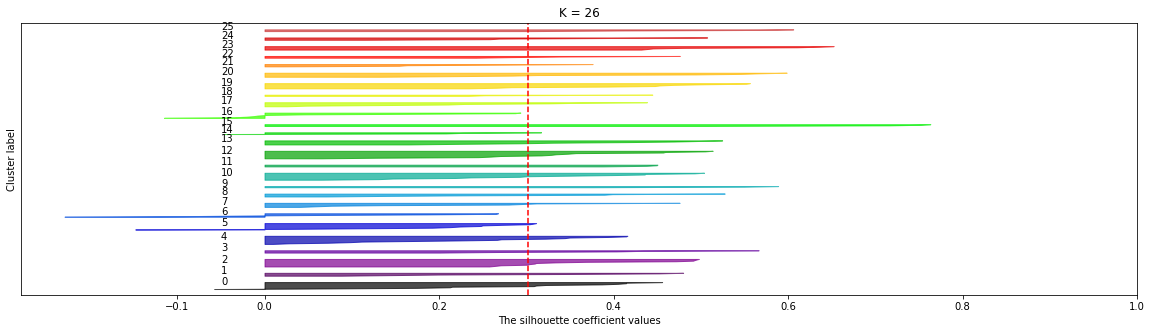

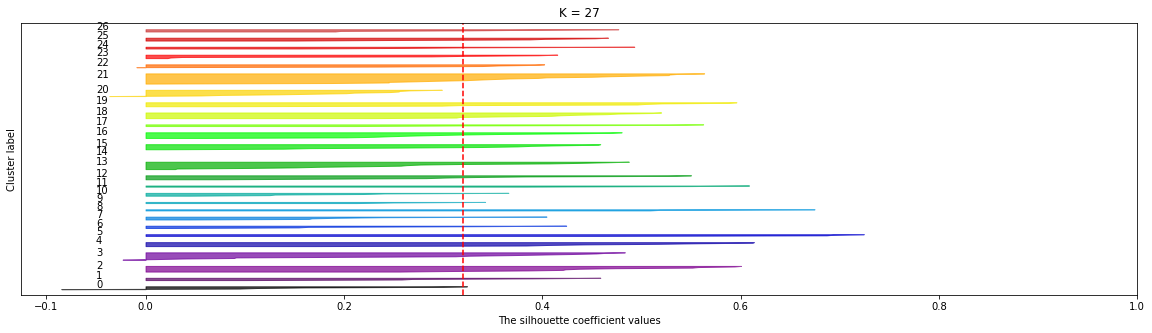

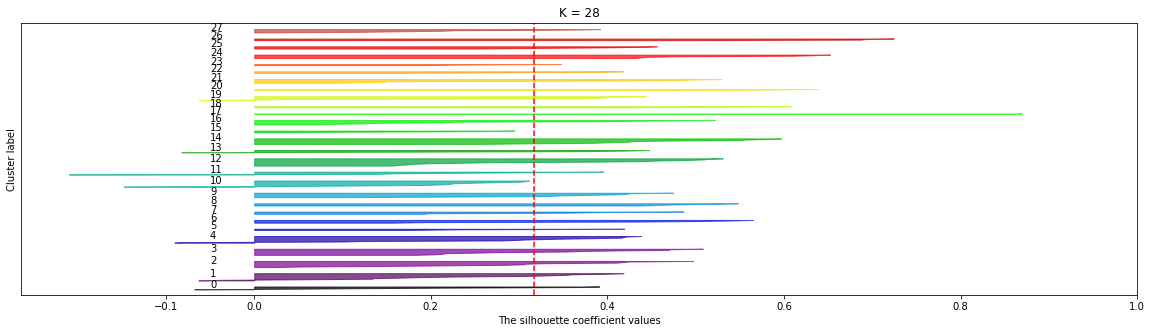

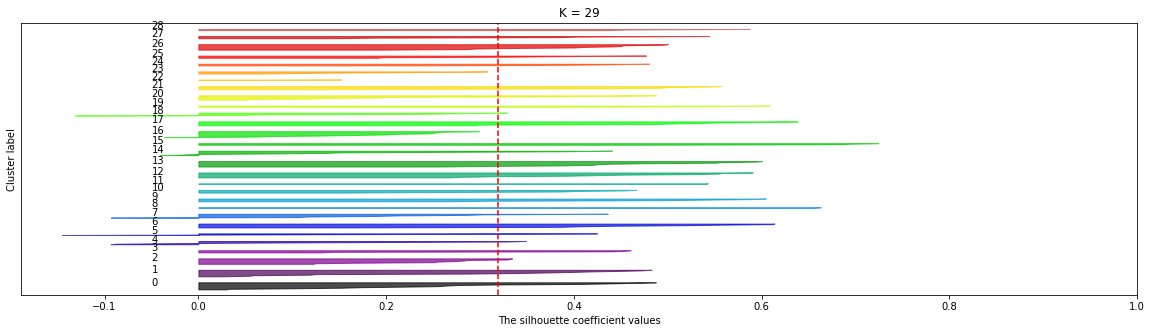

For n_clusters = 2 The average silhouette_score is : 0.33547192894004574
For n_clusters = 3 The average silhouette_score is : 0.35880977401117803
For n_clusters = 4 The average silhouette_score is : 0.4039582785148566
For n_clusters = 5 The average silhouette_score is : 0.41664341513732767
For n_clusters = 6 The average silhouette_score is : 0.42742814991580175
For n_clusters = 7 The average silhouette_score is : 0.417231894954916
For n_clusters = 8 The average silhouette_score is : 0.408443059554235
For n_clusters = 9 The average silhouette_score is : 0.4188078334648395
For n_clusters = 10 The average silhouette_score is : 0.4003965743727067
For n_clusters = 11 The average silhouette_score is : 0.40735982072930627
For n_clusters = 12 The average silhouette_score is : 0.41103506331859635
For n_clusters = 13 The average silhouette_score is : 0.37109188976467833
For n_clusters = 14 The average silhouette_score is : 0.3744783217222762
For n_clusters = 15 The average silhouette_score is : 

In [56]:
x=data[data.columns[2:]]
X=StandardScaler().fit_transform(x)
range_n_clusters = np.arange(2,30)
for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1, 1,figsize=(20,5))
    #fig.set_size_inches(15, 10)
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("K = {}".format(n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.show()

range_n_clusters = list(np.arange(2,30))

savergs=[]
for n_clusters in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    
    silhouette_avg = silhouette_score(X, cluster_labels)
    savergs.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

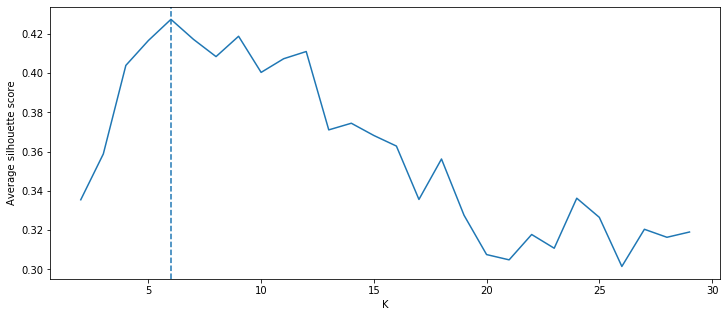

In [59]:
plt.figure(figsize=(12,5))
plt.plot(range_n_clusters,savergs)
plt.xlabel("K")
plt.ylabel("Average silhouette score")
plt.axvline(x=6,linestyle='--')
plt.show()

### So we can visualize our results

In [60]:
# finding the clusters based on input matrix "x"
model = KMeans(n_clusters = 6, random_state = 10)
y_clusters = model.fit_predict(X)
for angle in range(0,360,4):
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111, projection='3d')
    #colors=['blue', 'orange', 'green', '#D12B60' , 'purple', 'red']
    #for i in range(6):
    ax.scatter(X[:,0],X[:,1],X[:,2] , cmap='rainbow',c=model.labels_)
    ax.set_xlabel('Age')
    ax.set_ylabel('Anual Income')
    ax.set_zlabel('Spending Score')
    ax.view_init(35, angle)
    #plt.savefig('KMeans/'+str(angle).zfill(3)+'.png')
    plt.close()

![gif](./KMeans.gif)

## Now due to the fact that K-Means can change its results at every realization, we make use of a heavier tool named Hierarchical cluster 

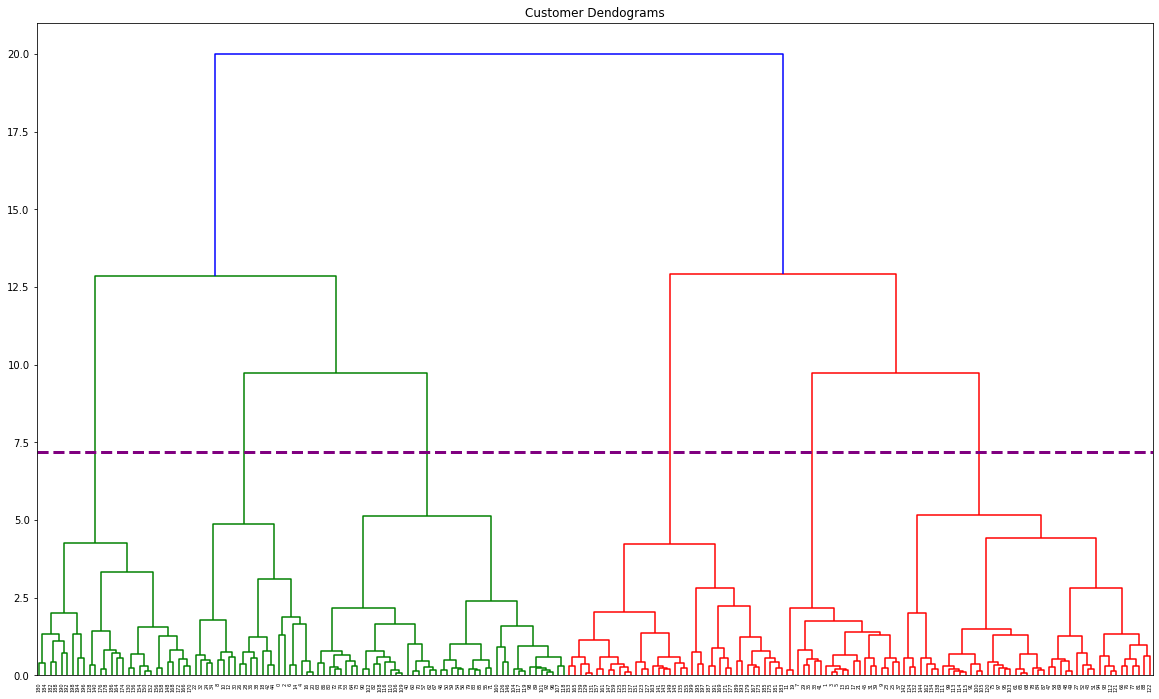

In [62]:
fig, ax = plt.subplots(1,1,figsize=(20, 12))

ax.set_title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'),ax=ax)
ax.axhline(y=7.2,linewidth=3,linestyle='--',color='purple')
plt.show()

In [65]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
labels=cluster.fit_predict(X)
for angle in range(0,360,4):
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1],X[:,2], c=cluster.labels_, cmap='rainbow')
    ax.set_xlabel('Age')
    ax.set_ylabel('Anual Income')
    ax.set_zlabel('Spending Score')
    ax.view_init(35, angle)
    #plt.savefig('Hierarchical clustering/'+str(angle).zfill(3)+'.png')
    plt.close()
data['cluster']=cluster.labels_

### Which at the end we get the same result

![gif](./Hierarchichal.gif)

# So we get the next results. (6 nice explained clusters)

In [66]:
data.groupby(['cluster']).mean()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
cluster,,,,
0,92.800000,27.377778,57.511111,45.844444
1,86.666667,56.400000,55.288889,48.355556
2,162.000000,32.692308,86.538462,82.128205
3,169.214286,43.892857,91.285714,16.678571
4,22.181818,44.318182,25.772727,20.272727
5,22.857143,24.809524,25.619048,80.238095
